In [15]:
from deepface import DeepFace
from deepface.commons import distance as dst
from deepface.detectors import FaceDetector
import time
import cv2
from glob import glob as gl
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
import threading

models = ["VGG-Face", "Facenet", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib"]
model_name = "Facenet"
recognizor = DeepFace.build_model(model_name)

In [16]:
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs, convert_output

num_classes = 1
tfrecord = None
weights = 'face-yolov3-tiny.tf'
classes = './yolov3_tf2/face.names'
size = 416
yolo = YoloV3Tiny(classes=num_classes)
yolo.load_weights(weights).expect_partial()

def face_detection(img_raw):
    img_orin = img_raw.copy()
    img_raw = tf.convert_to_tensor(img_raw, dtype=tf.uint8)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, size)
    boxes, scores, classes, nums = yolo(img)
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    output = convert_output(img, (boxes, scores, classes, nums))
    outputs = []
    for out in output:
        top, right, bottom, left = out
        top = 0 if top <0 else top
        right = 0 if right <0 else right
        bottom = 0 if bottom <0 else bottom
        left = 0 if left <0 else left
        face = img_orin[top:bottom, left:right]
        outputs.append([face, [left, top, right, bottom]])
    return outputs

In [ ]:
# detector_names = ['opencv','ssd','mtcnn', 'retinaface']
# detector_name = 'ssd'
# detector = FaceDetector.build_model(detector_name)

# def face_detection(img_raw):
#     faces = FaceDetector.detect_face(detector, detector_name, img_raw, align = False)
#     return faces

In [17]:
def distance(e1, e2):
    distance = dst.findEuclideanDistance(dst.l2_normalize(e1), dst.l2_normalize(e2))
    return distance

def show(img):
    plt.imshow(img[:, :, ::-1])
    plt.show()

In [18]:
def load_user(path):
    images = gl(path+"/*.jpg")
    info_file = path+"/info.txt"
    f = open(info_file, "r")
    content = f.readlines()
    info = {"uid": content[0][:-1],
             "name": content[1][:-1],
             "age": content[2][:-1],
             "permission": content[3][:-1],
             "more": content[4][:-1]
            }
    encoded_faces = []
    for image in images:
        img = cv2.imread(image)
        try:
            face = face_detection(img)[0][0]
            encoded_face = DeepFace.represent(face, model = recognizor, fast=True)
            encoded_faces.append(encoded_face)
        except:
            pass
        
    return {"info":info, "vectors": encoded_faces}

def load_data():
    paths = gl("users/*")
    data = {}
    for path in paths:
        user = load_user(path)
        data[user.get("info").get("uid")] = user
    return data

def distances_compute(encoded_face, user):
    vectors = user['vectors']
    distances = []
    for vector in vectors:
        distances.append(distance(vector, encoded_face))
    return np.array(distances)

def user_verify(face, threshold = 0.3):
    min_distance = 2
    found_key = None
    user_matched = None
    h, w = face.shape[:2]
    encoded_face = DeepFace.represent(face, model = recognizor, fast=True)
    for key in keys:
        distances = distances_compute(encoded_face, data[key])
        mean_dis, min_dis = np.mean(distances), np.min(distances)
        if min_dis < min_distance:
            found_key = key
            min_distance = min_dis
            user_matched = data[found_key]["info"]
    if min_distance<threshold:
        return min_distance, user_matched
    else:
        return min_distance, None

In [19]:
data = load_data()
keys = list(data.keys())

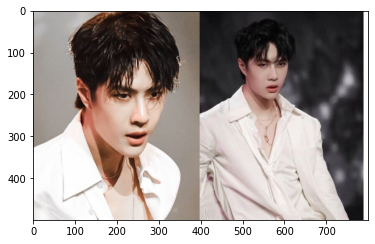

detect: 0.0340726375579834


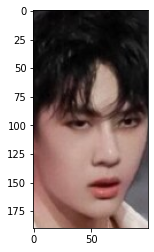

recognition 0.0567779541015625
0.6423028556804607
{'uid': '0006', 'name': 'Vuong Nhat Bac', 'age': '29', 'permission': '4', 'more': 'Dien vien Trung Quoc'}


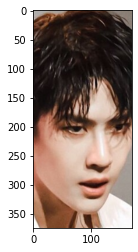

recognition 0.05099964141845703
0.7665292212199347
{'uid': '0006', 'name': 'Vuong Nhat Bac', 'age': '29', 'permission': '4', 'more': 'Dien vien Trung Quoc'}


In [21]:
threshold = 0.9
test_image = cv2.imread("3.jpg")
show(test_image)
import time
tik = time.time()
# faces detection
faces = face_detection(test_image)
tok = time.time()
print("detect:", tok -tik)
# face = cv2.imread("2.jpg")
for face in faces:
    show(face[0])
    tik = time.time()
    # face verify 
    min_distance, user_matched = user_verify(face[0], threshold = threshold)
    tok = time.time()
    print("recognition", tok -tik)
    print(min_distance)
    print(user_matched)

In [10]:
def deep_learning():
    print("deep_learning threading is started!")
    models = ["VGG-Face", "Facenet", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib"]
    model_name = "Facenet"
    recognizor = DeepFace.build_model(model_name)
    threshold = 0.85
    while cf.RUN:
        if cf.new_frame:
            t1 = time.time()
            outputs = []
            faces = face_detection(cf.frame)
            for face in faces: 
                face, pos = face[0], face[1]
                if face.shape[0]*face.shape[1]>0:
                    min_distance, user_matched = user_verify(face, threshold = threshold)
                    t6 = time.time()
                    user, rect_color = [user_matched['name'], (0, 255, 0)] if user_matched is not None else ["Unknown", (255, 0, 0)]
                    outputs.append([pos, user, min_distance, rect_color])
            cf.outputs = outputs
            cf.inference_time = time.time()
            cf.new_frame = False
            t2 = time.time()
            cf.fps1 = int(1/(t2-t1))
        else:
            time.sleep(0.01)
    print("deep_learning threading is stopped!")
    

In [24]:
import config as cf
cf.RUN = True
cf.new_frame = False
cf.inference_time = time.time()
cf.frame = None
cf.outputs = None
cf.fps1 = 0
deep_learning_thread = threading.Thread(target=deep_learning)
deep_learning_thread.start()
font = cv2.FONT_HERSHEY_SIMPLEX
# fontScale
fontScale = 0.7
# Blue color in BGR
color = (255, 0, 0)
# Line thickness of 2 px
thickness = 2
video_link = "rtsp://127.0.0.1:8554/test"
cap = cv2.VideoCapture(video_link)
t1 = time.time()
stt = 5
while True:
    stt+=1
    t2 = time.time()
    fps = int(1/(t2-t1))
    t1 = t2
    ret, frame = cap.read()
    cf.frame = frame
    cf.new_frame = True
    if not ret:
        break
    delta_time = time.time() - cf.inference_time
    if  delta_time <0.5:
        if cf.outputs is not None:
            for output in cf.outputs:
                pos, user, min_distance, rect_color = output
                cv2.rectangle(frame, (pos[0], pos[1]), (pos[2], pos[3]), rect_color, 2)
                cv2.putText(frame, user +"("+str(round(min_distance, 2))+")", (pos[0], pos[1]-10), font, 
                       fontScale, color, thickness, cv2.LINE_AA)
    cv2.putText(frame, "Deep learning FPS: "+str(round(cf.fps1)), (30, 30), font, 
               fontScale, color, thickness, cv2.LINE_AA)
    cv2.putText(frame, "Video FPS: "+str(fps), (30, 60), font, 
               fontScale, color, thickness, cv2.LINE_AA)
    cv2.putText(frame, "delta Time: "+str(round(delta_time, 4)), (30, 90), font, 
               fontScale, color, thickness, cv2.LINE_AA)
    cv2.imshow("frame", frame)
    time.sleep(0.001)
    k = cv2.waitKey(40)
    if k == ord('c'):
        cv2.imwrite(str(stt)+".jpg", frame)
    if k == ord('q'):
        cv2.destroyAllWindows()
        cf.RUN = False
        break

deep_learning threading is started!
deep_learning threading is stopped!
